# Facial Keypoint Detection

Welcome back for exercise 9! As we told you, the exercises of this lecture can be subdivided into mainly two parts. The first part in which we re-invented the wheel and implemented the most important methods on our own and the second part where we start using existing libraries (that already have implemented all the methods) and start playing around with more complex network architectures. 

We already entered stage two, but with the introduction of convolution neural networks this week, we are given a very powerful tool that we want to explore in this exercises. So let us start with this week's exercise, where we ask you to build a convolution neural network to perform facial keypoint detection. 

Before we start, let's take a look at some example images and corresponding facial keypoints:

<img src='images/key_pts_example.png' width=70% height=70%/>

The facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the images above. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. and are relevant for a variety of computer vision tasks, such as face filters, emotion recognition, pose recognition, and more. 

# 1. Preparation

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from exercise_code.data.facial_keypoints_dataset import FacialKeypointsDataset
from exercise_code.networks.keypoint_nn import (
    DummyKeypointModel,
    KeypointModel
)
from exercise_code.util import (
    show_all_keypoints,
    save_model,
)
from exercise_code.tests import test_keypoint_nn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but you can also run this notebook on your CPU.
         </p>
</div>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load and Visualize Data
To load the data, we have already prepared a Pytorch Dataset class `FacialKeypointsDataset` for you. You can find it in `exercise_code/data/facial_keypoints_dataset.py`. Run the following cell to download the data and initialize your dataset:

In [3]:
download_url = 'https://vision.in.tum.de/webshare/g/i2dl/facial_keypoints.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=transforms.ToTensor(),
    root=data_root,
    download_url=download_url
)
val_dataset = FacialKeypointsDataset(
    train=False,
    transform=transforms.ToTensor(),
    root=data_root,
)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 1546
Number of validation samples: 298


Each sample in our dataset is a dict `{"image": image, "keypoints": keypoints}`, where
 * `image` is a [0-1]-normalized gray-scale image of size 96x96, represented by a torch tensor of shape (CxHxW) with C=1, H=96, W=96
    <img style="float: right;" src='images/key_pts_expl.png' width=50% height=50%/>
 * `keypoints` is the list of K facial keypoints, stored in a torch tensor of shape (Kx2). We have K=15 keypoints that stand for:
   * keypoints[0]: Center of the left eye
   * keypoints[1]: Center of the right eye
   * keypoints[2]: Left eye inner corner
   * keypoints[3]: Left eye outer corner
   * keypoints[4]: Right eye inner corner
   * keypoints[5]: Right eye outer corner
   * keypoints[6]: Left eyebrow inner end
   * keypoints[7]: Left eyebrow outer end
   * keypoints[8]: Right eyebrow inner end
   * keypoints[9]: Right eyebrow outer end
   * keypoints[10]: Nose tip
   * keypoints[11]: Mouth left corner
   * keypoints[12]: Mouth right corner
   * keypoints[13]: Mouth center top lip
   * keypoints[14]: Mouth center bottom lip
   
Each individual facial keypoint is represented by two coordinates (x,y) that specify the horizontal and vertical location of the keypoint respectively. All keypoint values are normalized to [-1,1], such that:
   * (x=-1,y=-1) corresponds to the top left corner, 
   * (x=-1,y=1) to the bottom left corner,
   * (x=1,y=-1) to the top right corner,
   * (x=1,y=1) to the bottom right corner,
   * and (x=0,y=0) to the center of the image.
   
      
The data downloaded is already preprocessed and hence there is no need to apply transformations in order to prepare the data. Of course, feel free to apply training transformations to improve your performance such as e.g. flipping the training images. Do not forget that these transformations (data augmentation) are only applied to your training data. Your validation and test set remain untouched. Also, when applying transformations such as flipping, make sure that the predicted coordinates of your keypoints change accordingly.

Let's have a look at the first training sample to get a better feeling for the dataset:

In [4]:
image, keypoints = train_dataset[0]["image"], train_dataset[0]["keypoints"]
print("Shape of the image:", image.size())
print("Smallest value in the image:", torch.min(image))
print("Largest value in the image:", torch.max(image))
print(image)
print(image.shape)

Shape of the image: torch.Size([1, 96, 96])
Smallest value in the image: tensor(0.0118)
Largest value in the image: tensor(1.)
tensor([[[0.3804, 0.2039, 0.2275,  ..., 0.9922, 0.9961, 0.9961],
         [0.3333, 0.2157, 0.2588,  ..., 0.9922, 0.9961, 0.9961],
         [0.2941, 0.2588, 0.2902,  ..., 0.9922, 0.9961, 0.9961],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.9255, 1.0000, 1.0000],
         [0.1294, 0.1255, 0.1216,  ..., 0.9490, 0.9843, 0.9804],
         [0.1216, 0.1176, 0.1216,  ..., 0.9255, 1.0000, 0.9922]]])
torch.Size([1, 96, 96])


In [5]:
keypoints = train_dataset[0]["keypoints"]
print(keypoints)
print(keypoints.shape)

tensor([[ 0.4685, -0.2319],
        [-0.4253, -0.1953],
        [ 0.2908, -0.2214],
        [ 0.5992, -0.2214],
        [-0.2685, -0.2109],
        [-0.5873, -0.1900],
        [ 0.1967, -0.3827],
        [ 0.7656, -0.4295],
        [-0.2035, -0.3758],
        [-0.7389, -0.3573],
        [ 0.0086,  0.2333],
        [ 0.4163,  0.6620],
        [-0.3521,  0.6985],
        [ 0.0138,  0.6045],
        [ 0.0190,  0.9076]])
torch.Size([15, 2])


In `exercise_code/util/vis_utils.py` we also provide you with a function `show_all_keypoints()` that takes in an image and keypoints and displays where the predicted keypoints are in the image. Let's use it to plot the first few images of our training set:

**Note:** if your kernel dies when running the following cell, please uncomment the last line of the imports cell `os.environ['KMP_DUPLICATE_LIB_OK']='True'`and try it again. 

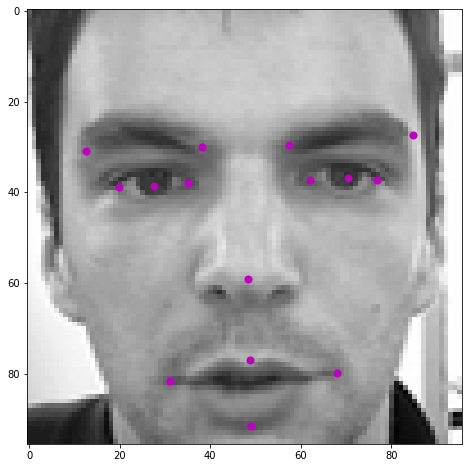

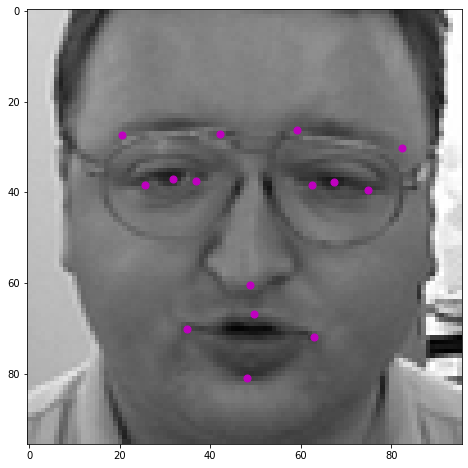

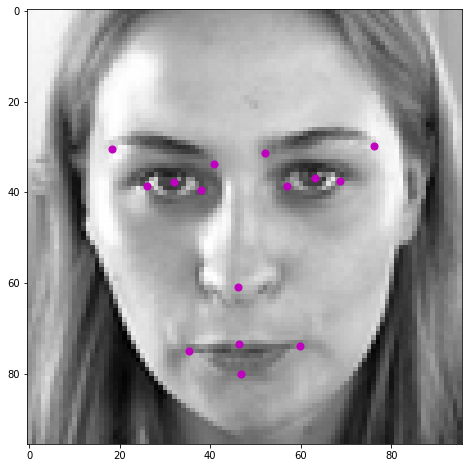

In [6]:
def show_keypoints(dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        show_all_keypoints(image, key_pts)
show_keypoints(train_dataset)

# 2. Facial Keypoint Detection
Your task is to define and train a model for facial keypoint detection.

The facial keypoint detection task can be seen as a regression problem, where the goal is to predict 30 different values that correspond to the 15 facial keypoint locations. Thus, we need to build a network that gets a (1x96x96) image as input and predicts 30 continuous outputs between [-1,1].

## Dummy Model

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>In <code>exercise_code/networks/keypoint_nn.py</code> we defined a naive <code>DummyKeypointModel</code>, which always predicts the keypoints of the first training image. Let's try it on a few images and visualize our predictions in red:
 </p>
</div>

In [7]:
def show_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        
        #images=images.unsqueeze(0)
        
        
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15,2)
        show_all_keypoints(image, key_pts, predicted_keypoints)

In [ ]:
dummy_model = DummyKeypointModel()
show_keypoint_predictions(dummy_model, train_dataset)

As we see, the model predicts the first sample perfectly, but for the remaining samples the predictions are quite off.

## Loss and Metrics

To measure the quality of the model's predictions, we will use the mean squared error (https://en.wikipedia.org/wiki/Mean_squared_error), summed up over all 30 keypoint locations. In PyTorch, the mean squared error is defined in `torch.nn.MSELoss()`, and we can use it like this:

In [ ]:
loss_fn = torch.nn.MSELoss()
for i in range(3):
    image = train_dataset[i]["image"]
    keypoints = train_dataset[i]["keypoints"]
    predicted_keypoints = torch.squeeze(dummy_model(image)).view(15,2)
    loss = loss_fn(keypoints, predicted_keypoints)
    print("Loss on image %d:" % i, loss)

As expected, our dummy model achieves a loss close to 0 on the first sample, but on all other samples the loss is quite high.

To obtain an evaluation score (in the notebook and on the submission server), we will use the following function:

In [ ]:
def evaluate_model(model, dataset):
    model.eval()
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"], batch["keypoints"]
        predicted_keypoints = model(image).view(-1,15,2)
        loss += criterion(
            torch.squeeze(keypoints),
            torch.squeeze(predicted_keypoints)
        ).item()
    return 1.0 / (2 * (loss/len(dataloader)))

print("Score of the Dummy Model:", evaluate_model(dummy_model, val_dataset))

**To pass the assignment, you will need to achieve a score of at least 100**. As you can see, the score is calculated from the average loss, so **your average loss needs to be lower than 0.005**. Our dummy model only gets a score of around 60, so you will have to come up with a better model.

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> Now it is your turn to build your own model. To do so, you need to design a convolution neural network that takes images of size (Nx1x96x96) as input and produces outputs of shape (Nx30) in the range [-1,1]. Therefore, implement the <code>KeypointModel</code> class in <code>exercise_code/networks/keypoint_nn.py</code>.
    </p>
</div>

Recall that CNN's are defined by a few types of layers:
* Convolution layers
* Max-pooling layers
* Fully-connected layers

You can design your network however you want, but we strongly suggest to include multiple convolution layers. You are also encouraged to use things like dropout and batch normalization to stabilize and regularize your network. If you want to build a really competitive model, have a look at some literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf).

#### Define your model in the provided file 
`exercise_code/networks/keypoint_nn.py` file

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). You are also free to decide whether you want to use PyTorch Lightning or not.
The only rules your model design has to follow are:
* Inherit from either `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in forward(), predicting keypoints of shape (Nx30) for images of shape (Nx1x96x96)
* Have less than 5 million parameters
* Have a model size of less than 20MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dictionary:

In [8]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here
    "batch_size":20,
    "n_hidden": 256,
    "learning_rate":1.3e-3
}  

To test whether your model follows the basic rules, run the following cell:

In [9]:
model = KeypointModel(hparams)
test_keypoint_nn(model)
#show_keypoint_predictions(model, train_dataset)

KeypointShapeTest passed.
ParamCountTest passed. Your model has 3.550 mio. params.
FileSizeTest passed. Your model is 14.2 MB large
All tests passed for your model. Tests passed: 3/3


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [12, 1, 3, 3], but got 3-dimensional input of size [1, 96, 96] instead

## Step 2: Train your model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

**Hints:**
* Use `torch.nn.MSELoss()` as loss function
* Have a look at the previous notebooks for PyTorch and PyTorch Lightning in exercises 7 and 8 if you feel lost. In particular, revise `1_Cifar10_PytorchLightning.ipynb` in the optional submission from Week 7.

In [23]:
########################################################################
# TODO - Train Your Model                                              #
########################################################################





import torch.optim as optim
from torch import nn
from exercise_code.networks.keypoint_nn import KeypointModel

def train_net(n_epochs):

    # prepare the net for training
    model.train()
    running_loss = 0.0
    data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(data_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            #print(key_pts[0], images[0])

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss += loss.item()
            

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1,
                                                                   batch_i+1,
                                                                   running_loss / (len(data_loader)*epoch+batch_i)))
            
            #return images, key_pts, output_pts

    print('Finished Training')

    
# Load model and run the solver

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
train_net(n_epochs=20)



                
"""def train(train_dataset, batch_size, epochs, learning_rate, wt_decay):
     # 载入数据并分割batch
     train_loader = data.DataLoader(train_dataset, batch_size)
     # 构建模型
     model = FaceCNN()
     # 损失函数
     loss_function = nn.CrossEntropyLoss()
     # 优化器
     optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wt_decay)
     # 学习率衰减
     # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
     # 逐轮训练
     for epoch in range(epochs):
         # 记录损失值
         loss_rate = 0
         # scheduler.step() # 学习率衰减
         model.train() # 模型训练
         for images, labels in train_loader:
             # 梯度清零
             optimizer.zero_grad()
             # 前向传播
             output = model.forward(images)
             # 误差计算
             loss_rate = loss_function(output, labels)
             # 误差的反向传播
             loss_rate.backward()
             # 更新参数
             optimizer.step()"""

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

Epoch: 1, Batch: 10, Avg. Loss: 6.034353661868307
Epoch: 1, Batch: 20, Avg. Loss: 3.8331779908192787
Epoch: 1, Batch: 30, Avg. Loss: 2.8937202984916754
Epoch: 1, Batch: 40, Avg. Loss: 2.3546132410948095
Epoch: 1, Batch: 50, Avg. Loss: 2.0286047960422477
Epoch: 1, Batch: 60, Avg. Loss: 1.8351245676561938
Epoch: 1, Batch: 70, Avg. Loss: 1.6749349493479384
Epoch: 1, Batch: 80, Avg. Loss: 1.520948987784265
Epoch: 1, Batch: 90, Avg. Loss: 1.414720544486903
Epoch: 1, Batch: 100, Avg. Loss: 1.3393581845242568
Epoch: 1, Batch: 110, Avg. Loss: 1.2692462767756314
Epoch: 1, Batch: 120, Avg. Loss: 1.1985562333539754
Epoch: 1, Batch: 130, Avg. Loss: 1.1576913412689238
Epoch: 1, Batch: 140, Avg. Loss: 1.1044620541359882
Epoch: 1, Batch: 150, Avg. Loss: 1.060579231621435
Epoch: 1, Batch: 160, Avg. Loss: 1.0198332577381495
Epoch: 1, Batch: 170, Avg. Loss: 0.9817145943818008
Epoch: 1, Batch: 180, Avg. Loss: 0.9447239986178595
Epoch: 1, Batch: 190, Avg. Loss: 0.9088688483313908
Epoch: 1, Batch: 200, Avg

Epoch: 2, Batch: 30, Avg. Loss: 0.15502166515127533
Epoch: 2, Batch: 40, Avg. Loss: 0.15410007211212245
Epoch: 2, Batch: 50, Avg. Loss: 0.1531967959822182
Epoch: 2, Batch: 60, Avg. Loss: 0.1523096807289439
Epoch: 2, Batch: 70, Avg. Loss: 0.1514372977523289
Epoch: 2, Batch: 80, Avg. Loss: 0.15055674394162802
Epoch: 2, Batch: 90, Avg. Loss: 0.1496995709665598
Epoch: 2, Batch: 100, Avg. Loss: 0.14884218310931624
Epoch: 2, Batch: 110, Avg. Loss: 0.14799041150396638
Epoch: 2, Batch: 120, Avg. Loss: 0.14714645464812312
Epoch: 2, Batch: 130, Avg. Loss: 0.14631476821822684
Epoch: 2, Batch: 140, Avg. Loss: 0.14549620774552469
Epoch: 2, Batch: 150, Avg. Loss: 0.14467896172230113
Epoch: 2, Batch: 160, Avg. Loss: 0.1438733524963795
Epoch: 2, Batch: 170, Avg. Loss: 0.14308160093718864
Epoch: 2, Batch: 180, Avg. Loss: 0.14229115416228338
Epoch: 2, Batch: 190, Avg. Loss: 0.14151096876324168
Epoch: 2, Batch: 200, Avg. Loss: 0.14074793347213577
Epoch: 2, Batch: 210, Avg. Loss: 0.13999076865963703
Epoch

Epoch: 3, Batch: 40, Avg. Loss: 0.08222476973900936
Epoch: 3, Batch: 50, Avg. Loss: 0.08197284583647227
Epoch: 3, Batch: 60, Avg. Loss: 0.08172602658230967
Epoch: 3, Batch: 70, Avg. Loss: 0.08147787502903477
Epoch: 3, Batch: 80, Avg. Loss: 0.08123316831557237
Epoch: 3, Batch: 90, Avg. Loss: 0.08099197333625024
Epoch: 3, Batch: 100, Avg. Loss: 0.08075019889314893
Epoch: 3, Batch: 110, Avg. Loss: 0.08050960644070607
Epoch: 3, Batch: 120, Avg. Loss: 0.08026870571061498
Epoch: 3, Batch: 130, Avg. Loss: 0.08002824461741331
Epoch: 3, Batch: 140, Avg. Loss: 0.07979345402299276
Epoch: 3, Batch: 150, Avg. Loss: 0.07955635470634574
Epoch: 3, Batch: 160, Avg. Loss: 0.07932147433772462
Epoch: 3, Batch: 170, Avg. Loss: 0.07908666662069175
Epoch: 3, Batch: 180, Avg. Loss: 0.0788521515192512
Epoch: 3, Batch: 190, Avg. Loss: 0.07862021065043105
Epoch: 3, Batch: 200, Avg. Loss: 0.07838968563154133
Epoch: 3, Batch: 210, Avg. Loss: 0.0781613048816178
Epoch: 3, Batch: 220, Avg. Loss: 0.0779346547491433
Ep

Epoch: 4, Batch: 40, Avg. Loss: 0.05663645818743115
Epoch: 4, Batch: 50, Avg. Loss: 0.05651967507367387
Epoch: 4, Batch: 60, Avg. Loss: 0.05640663077132485
Epoch: 4, Batch: 70, Avg. Loss: 0.05629177094425162
Epoch: 4, Batch: 80, Avg. Loss: 0.05617855871290978
Epoch: 4, Batch: 90, Avg. Loss: 0.05606551289398872
Epoch: 4, Batch: 100, Avg. Loss: 0.05595196015812216
Epoch: 4, Batch: 110, Avg. Loss: 0.05583953466163884
Epoch: 4, Batch: 120, Avg. Loss: 0.055726072184375586
Epoch: 4, Batch: 130, Avg. Loss: 0.055613424418341134
Epoch: 4, Batch: 140, Avg. Loss: 0.05550255260249646
Epoch: 4, Batch: 150, Avg. Loss: 0.05539246995702128
Epoch: 4, Batch: 160, Avg. Loss: 0.055281368797171354
Epoch: 4, Batch: 170, Avg. Loss: 0.05517144454729104
Epoch: 4, Batch: 180, Avg. Loss: 0.05506012227907483
Epoch: 4, Batch: 190, Avg. Loss: 0.05495025424086499
Epoch: 4, Batch: 200, Avg. Loss: 0.0548409821441255
Epoch: 4, Batch: 210, Avg. Loss: 0.054732341879590835
Epoch: 4, Batch: 220, Avg. Loss: 0.05462490966868

Epoch: 5, Batch: 40, Avg. Loss: 0.04343354571129164
Epoch: 5, Batch: 50, Avg. Loss: 0.04336659078477747
Epoch: 5, Batch: 60, Avg. Loss: 0.04330035432594441
Epoch: 5, Batch: 70, Avg. Loss: 0.0432337799715742
Epoch: 5, Batch: 80, Avg. Loss: 0.0431684069063986
Epoch: 5, Batch: 90, Avg. Loss: 0.043102900743223274
Epoch: 5, Batch: 100, Avg. Loss: 0.04303657288250772
Epoch: 5, Batch: 110, Avg. Loss: 0.0429714014350741
Epoch: 5, Batch: 120, Avg. Loss: 0.04290521918405015
Epoch: 5, Batch: 130, Avg. Loss: 0.04283974032373436
Epoch: 5, Batch: 140, Avg. Loss: 0.042774478024961995
Epoch: 5, Batch: 150, Avg. Loss: 0.04270995284355076
Epoch: 5, Batch: 160, Avg. Loss: 0.04264492538273222
Epoch: 5, Batch: 170, Avg. Loss: 0.04258014553307397
Epoch: 5, Batch: 180, Avg. Loss: 0.04251531266175603
Epoch: 5, Batch: 190, Avg. Loss: 0.042451013439903325
Epoch: 5, Batch: 200, Avg. Loss: 0.04238791467195182
Epoch: 5, Batch: 210, Avg. Loss: 0.042323437329324816
Epoch: 5, Batch: 220, Avg. Loss: 0.0422603335459100

Epoch: 6, Batch: 30, Avg. Loss: 0.03984731180753583
Epoch: 6, Batch: 40, Avg. Loss: 0.03980167951491163
Epoch: 6, Batch: 50, Avg. Loss: 0.03975612283464024
Epoch: 6, Batch: 60, Avg. Loss: 0.03971327051364549
Epoch: 6, Batch: 70, Avg. Loss: 0.03966721696852572
Epoch: 6, Batch: 80, Avg. Loss: 0.03962304815727507
Epoch: 6, Batch: 90, Avg. Loss: 0.03957851717538235
Epoch: 6, Batch: 100, Avg. Loss: 0.039531561199354165
Epoch: 6, Batch: 110, Avg. Loss: 0.03948515447151614
Epoch: 6, Batch: 120, Avg. Loss: 0.03943907111775306
Epoch: 6, Batch: 130, Avg. Loss: 0.03939373053311458
Epoch: 6, Batch: 140, Avg. Loss: 0.03934814434354217
Epoch: 6, Batch: 150, Avg. Loss: 0.03930256624384813
Epoch: 6, Batch: 160, Avg. Loss: 0.03925671090391917
Epoch: 6, Batch: 170, Avg. Loss: 0.0392122010338204
Epoch: 6, Batch: 180, Avg. Loss: 0.039166232166459265
Epoch: 6, Batch: 190, Avg. Loss: 0.03912152249992533
Epoch: 6, Batch: 200, Avg. Loss: 0.03907595632228047
Epoch: 6, Batch: 210, Avg. Loss: 0.03903058385397872

Epoch: 7, Batch: 30, Avg. Loss: 0.03397340899397352
Epoch: 7, Batch: 40, Avg. Loss: 0.03393874243655721
Epoch: 7, Batch: 50, Avg. Loss: 0.03390399341849453
Epoch: 7, Batch: 60, Avg. Loss: 0.03387008076657448
Epoch: 7, Batch: 70, Avg. Loss: 0.03383568292475279
Epoch: 7, Batch: 80, Avg. Loss: 0.03380252026099692
Epoch: 7, Batch: 90, Avg. Loss: 0.03376920220428256
Epoch: 7, Batch: 100, Avg. Loss: 0.033734962076864515
Epoch: 7, Batch: 110, Avg. Loss: 0.033701088890287806
Epoch: 7, Batch: 120, Avg. Loss: 0.03366674869806712
Epoch: 7, Batch: 130, Avg. Loss: 0.03363253666271613
Epoch: 7, Batch: 140, Avg. Loss: 0.03359861968080409
Epoch: 7, Batch: 150, Avg. Loss: 0.03356514315978088
Epoch: 7, Batch: 160, Avg. Loss: 0.03353111499596104
Epoch: 7, Batch: 170, Avg. Loss: 0.03349775419541048
Epoch: 7, Batch: 180, Avg. Loss: 0.03346362005494927
Epoch: 7, Batch: 190, Avg. Loss: 0.033429963486817676
Epoch: 7, Batch: 200, Avg. Loss: 0.03339639700646328
Epoch: 7, Batch: 210, Avg. Loss: 0.033362919840887

Epoch: 8, Batch: 20, Avg. Loss: 0.029624302351124853
Epoch: 8, Batch: 30, Avg. Loss: 0.02960081358920258
Epoch: 8, Batch: 40, Avg. Loss: 0.029575685223523517
Epoch: 8, Batch: 50, Avg. Loss: 0.02955003890625408
Epoch: 8, Batch: 60, Avg. Loss: 0.029525324046994723
Epoch: 8, Batch: 70, Avg. Loss: 0.029499481102358813
Epoch: 8, Batch: 80, Avg. Loss: 0.029475055650583268
Epoch: 8, Batch: 90, Avg. Loss: 0.02945012482839564
Epoch: 8, Batch: 100, Avg. Loss: 0.029424999460776705
Epoch: 8, Batch: 110, Avg. Loss: 0.029399977666938668
Epoch: 8, Batch: 120, Avg. Loss: 0.029374774085765647
Epoch: 8, Batch: 130, Avg. Loss: 0.029349350557267003
Epoch: 8, Batch: 140, Avg. Loss: 0.029323846578738686
Epoch: 8, Batch: 150, Avg. Loss: 0.029298654038028206
Epoch: 8, Batch: 160, Avg. Loss: 0.029273559625357683
Epoch: 8, Batch: 170, Avg. Loss: 0.029248460651602633
Epoch: 8, Batch: 180, Avg. Loss: 0.02922301188677572
Epoch: 8, Batch: 190, Avg. Loss: 0.029197664676597422
Epoch: 8, Batch: 200, Avg. Loss: 0.02917

Epoch: 8, Batch: 1540, Avg. Loss: 0.026374743300277215
Epoch: 9, Batch: 10, Avg. Loss: 0.02634473381346851
Epoch: 9, Batch: 20, Avg. Loss: 0.026325562853616636
Epoch: 9, Batch: 30, Avg. Loss: 0.026306430264101052
Epoch: 9, Batch: 40, Avg. Loss: 0.026286832611343295
Epoch: 9, Batch: 50, Avg. Loss: 0.02626727995471163
Epoch: 9, Batch: 60, Avg. Loss: 0.026248014078061866
Epoch: 9, Batch: 70, Avg. Loss: 0.026228434605459414
Epoch: 9, Batch: 80, Avg. Loss: 0.026209273986699772
Epoch: 9, Batch: 90, Avg. Loss: 0.026189860365977476
Epoch: 9, Batch: 100, Avg. Loss: 0.026170389293025256
Epoch: 9, Batch: 110, Avg. Loss: 0.026151261994218526
Epoch: 9, Batch: 120, Avg. Loss: 0.02613160439794474
Epoch: 9, Batch: 130, Avg. Loss: 0.02611227579185321
Epoch: 9, Batch: 140, Avg. Loss: 0.026092775108667084
Epoch: 9, Batch: 150, Avg. Loss: 0.026073349746732328
Epoch: 9, Batch: 160, Avg. Loss: 0.02605450107019121
Epoch: 9, Batch: 170, Avg. Loss: 0.02603500211046715
Epoch: 9, Batch: 180, Avg. Loss: 0.0260155

Epoch: 9, Batch: 1520, Avg. Loss: 0.030570767558999037
Epoch: 9, Batch: 1530, Avg. Loss: 0.03055941222053134
Epoch: 9, Batch: 1540, Avg. Loss: 0.030543256507713716
Epoch: 10, Batch: 10, Avg. Loss: 0.03052531810189402
Epoch: 10, Batch: 20, Avg. Loss: 0.030514818160641322
Epoch: 10, Batch: 30, Avg. Loss: 0.030501625234923543
Epoch: 10, Batch: 40, Avg. Loss: 0.030486783562224663
Epoch: 10, Batch: 50, Avg. Loss: 0.03046997967076549
Epoch: 10, Batch: 60, Avg. Loss: 0.03045744262812126
Epoch: 10, Batch: 70, Avg. Loss: 0.03044575128944475
Epoch: 10, Batch: 80, Avg. Loss: 0.03042931567658952
Epoch: 10, Batch: 90, Avg. Loss: 0.030413169329652684
Epoch: 10, Batch: 100, Avg. Loss: 0.03039629152714044
Epoch: 10, Batch: 110, Avg. Loss: 0.030382496127947668
Epoch: 10, Batch: 120, Avg. Loss: 0.03036856359827132
Epoch: 10, Batch: 130, Avg. Loss: 0.03035151537291099
Epoch: 10, Batch: 140, Avg. Loss: 0.030335006904078126
Epoch: 10, Batch: 150, Avg. Loss: 0.030319147499723535
Epoch: 10, Batch: 160, Avg. 

Epoch: 10, Batch: 1480, Avg. Loss: 0.028285415721818766
Epoch: 10, Batch: 1490, Avg. Loss: 0.028270154520038105
Epoch: 10, Batch: 1500, Avg. Loss: 0.02825645059006925
Epoch: 10, Batch: 1510, Avg. Loss: 0.028241501186294274
Epoch: 10, Batch: 1520, Avg. Loss: 0.028225692727397826
Epoch: 10, Batch: 1530, Avg. Loss: 0.028210071777238947
Epoch: 10, Batch: 1540, Avg. Loss: 0.028194107840050702
Epoch: 11, Batch: 10, Avg. Loss: 0.028170830205192274
Epoch: 11, Batch: 20, Avg. Loss: 0.0281553426540685
Epoch: 11, Batch: 30, Avg. Loss: 0.028139717052862577
Epoch: 11, Batch: 40, Avg. Loss: 0.02812388804520789
Epoch: 11, Batch: 50, Avg. Loss: 0.028107451645038854
Epoch: 11, Batch: 60, Avg. Loss: 0.02809146323603472
Epoch: 11, Batch: 70, Avg. Loss: 0.028074945939162516
Epoch: 11, Batch: 80, Avg. Loss: 0.028059101957091045
Epoch: 11, Batch: 90, Avg. Loss: 0.02804247361741425
Epoch: 11, Batch: 100, Avg. Loss: 0.028025656405636076
Epoch: 11, Batch: 110, Avg. Loss: 0.02800912158387379
Epoch: 11, Batch: 1

Epoch: 11, Batch: 1440, Avg. Loss: 0.02606330517654288
Epoch: 11, Batch: 1450, Avg. Loss: 0.026049685560650244
Epoch: 11, Batch: 1460, Avg. Loss: 0.0260360953404706
Epoch: 11, Batch: 1470, Avg. Loss: 0.02602336500361239
Epoch: 11, Batch: 1480, Avg. Loss: 0.02601035206654484
Epoch: 11, Batch: 1490, Avg. Loss: 0.02599737939656153
Epoch: 11, Batch: 1500, Avg. Loss: 0.02598544820303572
Epoch: 11, Batch: 1510, Avg. Loss: 0.0259725445872804
Epoch: 11, Batch: 1520, Avg. Loss: 0.02595901125592261
Epoch: 11, Batch: 1530, Avg. Loss: 0.025944994323666298
Epoch: 11, Batch: 1540, Avg. Loss: 0.025930788998852736
Epoch: 12, Batch: 10, Avg. Loss: 0.025908996399451042
Epoch: 12, Batch: 20, Avg. Loss: 0.025895196099052064
Epoch: 12, Batch: 30, Avg. Loss: 0.025881187988613004
Epoch: 12, Batch: 40, Avg. Loss: 0.025867244158290933
Epoch: 12, Batch: 50, Avg. Loss: 0.025852977036765652
Epoch: 12, Batch: 60, Avg. Loss: 0.02583897441987564
Epoch: 12, Batch: 70, Avg. Loss: 0.02582487582922797
Epoch: 12, Batch: 

Epoch: 12, Batch: 1400, Avg. Loss: 0.024183554674820182
Epoch: 12, Batch: 1410, Avg. Loss: 0.02417260166566438
Epoch: 12, Batch: 1420, Avg. Loss: 0.024161744121347743
Epoch: 12, Batch: 1430, Avg. Loss: 0.02415061331912509
Epoch: 12, Batch: 1440, Avg. Loss: 0.024139573523573658
Epoch: 12, Batch: 1450, Avg. Loss: 0.024127997928067503
Epoch: 12, Batch: 1460, Avg. Loss: 0.024116587175661962
Epoch: 12, Batch: 1470, Avg. Loss: 0.024105687968754896
Epoch: 12, Batch: 1480, Avg. Loss: 0.02409431413745292
Epoch: 12, Batch: 1490, Avg. Loss: 0.02408358594963189
Epoch: 12, Batch: 1500, Avg. Loss: 0.024073069370187536
Epoch: 12, Batch: 1510, Avg. Loss: 0.024062305514700334
Epoch: 12, Batch: 1520, Avg. Loss: 0.02405072104916361
Epoch: 12, Batch: 1530, Avg. Loss: 0.02403887881287081
Epoch: 12, Batch: 1540, Avg. Loss: 0.02402692602053257
Epoch: 13, Batch: 10, Avg. Loss: 0.024008830985983814
Epoch: 13, Batch: 20, Avg. Loss: 0.023997149257748797
Epoch: 13, Batch: 30, Avg. Loss: 0.02398567123439614
Epoch:

Epoch: 13, Batch: 1360, Avg. Loss: 0.02260734933294645
Epoch: 13, Batch: 1370, Avg. Loss: 0.022597758772870267
Epoch: 13, Batch: 1380, Avg. Loss: 0.022588326466621834
Epoch: 13, Batch: 1390, Avg. Loss: 0.022579338914043807
Epoch: 13, Batch: 1400, Avg. Loss: 0.022570756441667724
Epoch: 13, Batch: 1410, Avg. Loss: 0.022563145395084337
Epoch: 13, Batch: 1420, Avg. Loss: 0.02255476824198357
Epoch: 13, Batch: 1430, Avg. Loss: 0.022545888372809735
Epoch: 13, Batch: 1440, Avg. Loss: 0.022537518115011427
Epoch: 13, Batch: 1450, Avg. Loss: 0.02252857430432501
Epoch: 13, Batch: 1460, Avg. Loss: 0.0225191767991202
Epoch: 13, Batch: 1470, Avg. Loss: 0.022511308329280548
Epoch: 13, Batch: 1480, Avg. Loss: 0.022503672297714324
Epoch: 13, Batch: 1490, Avg. Loss: 0.02249528433216206
Epoch: 13, Batch: 1500, Avg. Loss: 0.022486764581315804
Epoch: 13, Batch: 1510, Avg. Loss: 0.022477273693895784
Epoch: 13, Batch: 1520, Avg. Loss: 0.022467944648134088
Epoch: 13, Batch: 1530, Avg. Loss: 0.02245836193902607

Epoch: 14, Batch: 1320, Avg. Loss: 0.021253496230701812
Epoch: 14, Batch: 1330, Avg. Loss: 0.021245893458194293
Epoch: 14, Batch: 1340, Avg. Loss: 0.0212382354065219
Epoch: 14, Batch: 1350, Avg. Loss: 0.021230621086806383
Epoch: 14, Batch: 1360, Avg. Loss: 0.021223113483699426
Epoch: 14, Batch: 1370, Avg. Loss: 0.0212149781376392
Epoch: 14, Batch: 1380, Avg. Loss: 0.021206616226530826
Epoch: 14, Batch: 1390, Avg. Loss: 0.021199241855297795
Epoch: 14, Batch: 1400, Avg. Loss: 0.021191312109023027
Epoch: 14, Batch: 1410, Avg. Loss: 0.021183851704366485
Epoch: 14, Batch: 1420, Avg. Loss: 0.021176415899661488
Epoch: 14, Batch: 1430, Avg. Loss: 0.021168734400100822
Epoch: 14, Batch: 1440, Avg. Loss: 0.021161514998787684
Epoch: 14, Batch: 1450, Avg. Loss: 0.021154753093949194
Epoch: 14, Batch: 1460, Avg. Loss: 0.021146863396044328
Epoch: 14, Batch: 1470, Avg. Loss: 0.02113913332642596
Epoch: 14, Batch: 1480, Avg. Loss: 0.021132226207356383
Epoch: 14, Batch: 1490, Avg. Loss: 0.0211243636494319

Epoch: 15, Batch: 1270, Avg. Loss: 0.020065930818509978
Epoch: 15, Batch: 1280, Avg. Loss: 0.020064149673579917
Epoch: 15, Batch: 1290, Avg. Loss: 0.020058978129704974
Epoch: 15, Batch: 1300, Avg. Loss: 0.020053802120300418
Epoch: 15, Batch: 1310, Avg. Loss: 0.020049254731193837
Epoch: 15, Batch: 1320, Avg. Loss: 0.020044995744758168
Epoch: 15, Batch: 1330, Avg. Loss: 0.020039749388965224
Epoch: 15, Batch: 1340, Avg. Loss: 0.02003390203293708
Epoch: 15, Batch: 1350, Avg. Loss: 0.020027141895929235
Epoch: 15, Batch: 1360, Avg. Loss: 0.020020796385117758
Epoch: 15, Batch: 1370, Avg. Loss: 0.020014264406515807
Epoch: 15, Batch: 1380, Avg. Loss: 0.020007261005710868
Epoch: 15, Batch: 1390, Avg. Loss: 0.020000639516875744
Epoch: 15, Batch: 1400, Avg. Loss: 0.019993880528415765
Epoch: 15, Batch: 1410, Avg. Loss: 0.019987659500199643
Epoch: 15, Batch: 1420, Avg. Loss: 0.019981007558166165
Epoch: 15, Batch: 1430, Avg. Loss: 0.019974113200203408
Epoch: 15, Batch: 1440, Avg. Loss: 0.019968938106

Epoch: 16, Batch: 1230, Avg. Loss: 0.019006926698359974
Epoch: 16, Batch: 1240, Avg. Loss: 0.019001070491709793
Epoch: 16, Batch: 1250, Avg. Loss: 0.01899589507954012
Epoch: 16, Batch: 1260, Avg. Loss: 0.01899099474808151
Epoch: 16, Batch: 1270, Avg. Loss: 0.018986190289114628
Epoch: 16, Batch: 1280, Avg. Loss: 0.018982021601865916
Epoch: 16, Batch: 1290, Avg. Loss: 0.018976739490496664
Epoch: 16, Batch: 1300, Avg. Loss: 0.01897166338526325
Epoch: 16, Batch: 1310, Avg. Loss: 0.01896597401082994
Epoch: 16, Batch: 1320, Avg. Loss: 0.018960355285164703
Epoch: 16, Batch: 1330, Avg. Loss: 0.018953979897206256
Epoch: 16, Batch: 1340, Avg. Loss: 0.018947628839605424
Epoch: 16, Batch: 1350, Avg. Loss: 0.01894172796334122
Epoch: 16, Batch: 1360, Avg. Loss: 0.01893580395375267
Epoch: 16, Batch: 1370, Avg. Loss: 0.01892947294341508
Epoch: 16, Batch: 1380, Avg. Loss: 0.018923089920822582
Epoch: 16, Batch: 1390, Avg. Loss: 0.018916533609871784
Epoch: 16, Batch: 1400, Avg. Loss: 0.018910485113693268

Epoch: 17, Batch: 1190, Avg. Loss: 0.018040891194769083
Epoch: 17, Batch: 1200, Avg. Loss: 0.018035873563100872
Epoch: 17, Batch: 1210, Avg. Loss: 0.018030360082203354
Epoch: 17, Batch: 1220, Avg. Loss: 0.018024564346452332
Epoch: 17, Batch: 1230, Avg. Loss: 0.01801926121913756
Epoch: 17, Batch: 1240, Avg. Loss: 0.0180137346064783
Epoch: 17, Batch: 1250, Avg. Loss: 0.018008067155478095
Epoch: 17, Batch: 1260, Avg. Loss: 0.01800286641932573
Epoch: 17, Batch: 1270, Avg. Loss: 0.01799787010340048
Epoch: 17, Batch: 1280, Avg. Loss: 0.01799311501966942
Epoch: 17, Batch: 1290, Avg. Loss: 0.01798806663172044
Epoch: 17, Batch: 1300, Avg. Loss: 0.017982898605591702
Epoch: 17, Batch: 1310, Avg. Loss: 0.017977340205679017
Epoch: 17, Batch: 1320, Avg. Loss: 0.017972394389363898
Epoch: 17, Batch: 1330, Avg. Loss: 0.01796674778649109
Epoch: 17, Batch: 1340, Avg. Loss: 0.017960781638976187
Epoch: 17, Batch: 1350, Avg. Loss: 0.01795522184302414
Epoch: 17, Batch: 1360, Avg. Loss: 0.017949314372486702
E

Epoch: 18, Batch: 1150, Avg. Loss: 0.017159621120130534
Epoch: 18, Batch: 1160, Avg. Loss: 0.01715465763457933
Epoch: 18, Batch: 1170, Avg. Loss: 0.017149144658010842
Epoch: 18, Batch: 1180, Avg. Loss: 0.017144005057607273
Epoch: 18, Batch: 1190, Avg. Loss: 0.017138773218589365
Epoch: 18, Batch: 1200, Avg. Loss: 0.017133902747866813
Epoch: 18, Batch: 1210, Avg. Loss: 0.01712873817937296
Epoch: 18, Batch: 1220, Avg. Loss: 0.017123230567656713
Epoch: 18, Batch: 1230, Avg. Loss: 0.01711799528520763
Epoch: 18, Batch: 1240, Avg. Loss: 0.01711245629612976
Epoch: 18, Batch: 1250, Avg. Loss: 0.017107238980139005
Epoch: 18, Batch: 1260, Avg. Loss: 0.017102367526199015
Epoch: 18, Batch: 1270, Avg. Loss: 0.017097076333612928
Epoch: 18, Batch: 1280, Avg. Loss: 0.01709228808105045
Epoch: 18, Batch: 1290, Avg. Loss: 0.01708741972993104
Epoch: 18, Batch: 1300, Avg. Loss: 0.01708243722621413
Epoch: 18, Batch: 1310, Avg. Loss: 0.017077464012489774
Epoch: 18, Batch: 1320, Avg. Loss: 0.017072825913711884

Epoch: 19, Batch: 1110, Avg. Loss: 0.016348625728008475
Epoch: 19, Batch: 1120, Avg. Loss: 0.016343951335998884
Epoch: 19, Batch: 1130, Avg. Loss: 0.016339377258963693
Epoch: 19, Batch: 1140, Avg. Loss: 0.016334849294179152
Epoch: 19, Batch: 1150, Avg. Loss: 0.01632983270676265
Epoch: 19, Batch: 1160, Avg. Loss: 0.016325208050084198
Epoch: 19, Batch: 1170, Avg. Loss: 0.016320562913358188
Epoch: 19, Batch: 1180, Avg. Loss: 0.016315781733579185
Epoch: 19, Batch: 1190, Avg. Loss: 0.0163109712457281
Epoch: 19, Batch: 1200, Avg. Loss: 0.01630600749222503
Epoch: 19, Batch: 1210, Avg. Loss: 0.016301131463459687
Epoch: 19, Batch: 1220, Avg. Loss: 0.01629609170022684
Epoch: 19, Batch: 1230, Avg. Loss: 0.01629134146582061
Epoch: 19, Batch: 1240, Avg. Loss: 0.016286493389587257
Epoch: 19, Batch: 1250, Avg. Loss: 0.016281805490625943
Epoch: 19, Batch: 1260, Avg. Loss: 0.016277296953171247
Epoch: 19, Batch: 1270, Avg. Loss: 0.016272316496964007
Epoch: 19, Batch: 1280, Avg. Loss: 0.01626791967757743

Epoch: 20, Batch: 1070, Avg. Loss: 0.015604521172527398
Epoch: 20, Batch: 1080, Avg. Loss: 0.015600102965021434
Epoch: 20, Batch: 1090, Avg. Loss: 0.015595932432611726
Epoch: 20, Batch: 1100, Avg. Loss: 0.015591600814478352
Epoch: 20, Batch: 1110, Avg. Loss: 0.015587414759615887
Epoch: 20, Batch: 1120, Avg. Loss: 0.015582925950889117
Epoch: 20, Batch: 1130, Avg. Loss: 0.015578645641608602
Epoch: 20, Batch: 1140, Avg. Loss: 0.01557442236747857
Epoch: 20, Batch: 1150, Avg. Loss: 0.01556982978463649
Epoch: 20, Batch: 1160, Avg. Loss: 0.015565534849916874
Epoch: 20, Batch: 1170, Avg. Loss: 0.015560872107543445
Epoch: 20, Batch: 1180, Avg. Loss: 0.015556497724345834
Epoch: 20, Batch: 1190, Avg. Loss: 0.015552112096519842
Epoch: 20, Batch: 1200, Avg. Loss: 0.015547736592242751
Epoch: 20, Batch: 1210, Avg. Loss: 0.01554330924676042
Epoch: 20, Batch: 1220, Avg. Loss: 0.015538732408358116
Epoch: 20, Batch: 1230, Avg. Loss: 0.015534323816721726
Epoch: 20, Batch: 1240, Avg. Loss: 0.01552978963712

'def train(train_dataset, batch_size, epochs, learning_rate, wt_decay):\n     # 载入数据并分割batch\n     train_loader = data.DataLoader(train_dataset, batch_size)\n     # 构建模型\n     model = FaceCNN()\n     # 损失函数\n     loss_function = nn.CrossEntropyLoss()\n     # 优化器\n     optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wt_decay)\n     # 学习率衰减\n     # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)\n     # 逐轮训练\n     for epoch in range(epochs):\n         # 记录损失值\n         loss_rate = 0\n         # scheduler.step() # 学习率衰减\n         model.train() # 模型训练\n         for images, labels in train_loader:\n             # 梯度清零\n             optimizer.zero_grad()\n             # 前向传播\n             output = model.forward(images)\n             # 误差计算\n             loss_rate = loss_function(output, labels)\n             # 误差的反向传播\n             loss_rate.backward()\n             # 更新参数\n             optimizer.step()'

When you're done training, run the cells below to visualize some predictions of your model, and to compute a validation score:

In [24]:
show_keypoint_predictions(model, val_dataset)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [12, 1, 3, 3], but got 3-dimensional input of size [1, 96, 96] instead

In [27]:
def evaluate_model(model, dataset):
    model.eval()
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"], batch["keypoints"]
        predicted_keypoints = model(image).view(-1,15,2)
        loss += criterion(
            torch.squeeze(keypoints),
            torch.squeeze(predicted_keypoints)
        ).item()
    return 1.0 / (2 * (loss/len(dataloader)))


print("Score:", evaluate_model(model, val_dataset))

Score: 179.99873681217838


# 3. Save Your Model for Submission

If your model achieved a validation score of 100 or higher, save your model with the cell below and submit it to [the submission server](https://i2dl.vc.in.tum.de). Your validation set is of course different from the test set on our server, so results may vary. Nevertheless, you will have a reasonable close approximation about your performance.

Before that, we will check again whether the number of parameters is below 5 Mio. and the file size is below 20 MB.

In [28]:
save_model(model, "facial_keypoints.p")

'models/facial_keypoints.p'

Congrats - you've now finished your first Convolution Neural Network! Simply run the following cell to create a zipped file for your implementations.

In [29]:
# Now zip the folder for upload
from exercise_code.util.submit import submit_exercise

submit_exercise('exercise09')

relevant folders: ['exercise_code', 'models']
notebooks files: ['Optional-spatial_batchnorm.ipynb', '1_facial_keypoints.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook Optional-spatial_batchnorm.ipynb
Adding notebook 1_facial_keypoints.ipynb
Zipping successful! Zip is stored under: /Users/meiqiliu/Downloads/exercise_09/exercise09.zip


# Submission Goals

- Goal: Implement and train a convolution neural network for facial keypoint detection.
- Passing Criteria: Reach **Score >= 100** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thursday, June 10, 2021 - 13:00__
- Submission deadline: __Wednesday, June 16, 2021 - 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus